In [1]:
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import tf_slim as slim
import functools 
import seaborn as sns
def tensor_size(tensor): 
    from operator import mul 
    return functools.reduce(mul, (d.value for d in tensor.get_shape()), 1)

from keras.backend import tensorflow_backend as K
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
K.set_session(tf.Session(config=config))

Using TensorFlow backend.


In [2]:
def next_batch( features, batch_size ): 
    #batch_size = 50

    num_samples = features.shape[0]
    rand_index = np.random.permutation(num_samples)

    cur_index = 0
    
    while True:
        if cur_index + batch_size > num_samples:
            rand_index = np.random.permutation(num_samples)
            cur_index = 0

        cur_index = cur_index + batch_size
        #print(features[ rand_index[cur_index-batch_size:cur_index], : ])
        yield features[ rand_index[cur_index-batch_size:cur_index], : ]
        
        
def runtime_label_ftn( input, p ):

    x = input.copy()
    thres_pos = np.int32 (x.shape[0] * p )
    x = np.sort(x, axis=0)
    thres = x[ thres_pos ]

    x = np.zeros_like(x)
    x[ np.where(input<thres)] = 1.0
    
    return x

In [3]:
class_specs = [ [-10, 5, 1000, -1], [0, 5, 1000, 0], [10, 5, 1000, 1] ] # [ mean, std, size, label ]
class_specs = np.array(class_specs, dtype=np.float32)

In [4]:
features = []
labels = []

for idx, class_spec in enumerate(class_specs):
    m = class_spec[0]
    std = class_spec[1]
    size = int(class_spec[2])
    x = np.random.normal(loc=m, scale=std, size=(size,1))
    y = np.random.normal(loc=m, scale=std, size=(size,1))
    #label = np.ones(shape=(size,1)) * (idx-1)
    label = np.ones(shape=(size,1)) * class_specs[idx,3]
    labels.append(class_specs[idx,3])
    data = np.concatenate((x, y, label), axis=1)
    features += list(data)
    #features.append(data)
    
features = np.array(features, dtype=np.float32)
#label1 = class_specs[0,3]
#label2 = class_specs[1,3]
#label3 = class_specs[2,3]
print(labels)

[-1.0, 0.0, 1.0]


In [5]:
n_len = 500
test_x = np.linspace( -20, 20, n_len ).reshape(-1,1)
test_y = np.linspace( -20, 20, n_len ).reshape(-1,1)
test_vector = np.hstack( (test_x, test_y) )

In [6]:
np.savetxt("./toy/data/toy_data.npy", features)
np.savetxt("./toy/data/test_vector.npy", test_vector)

In [3]:
features = np.loadtxt("./toy/data/toy_data.npy")
test_vector = np.loadtxt("./toy/data/test_vector.npy")
labels = [-1, 0, 1]

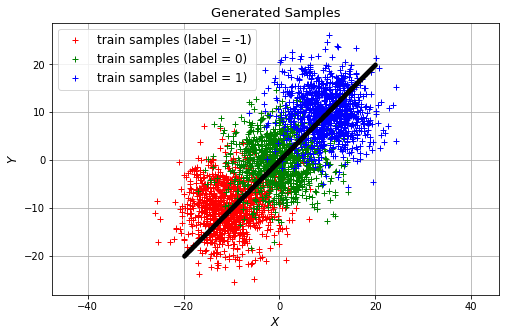

In [67]:
fmts = ["r+", "g+", "b+", "k+", "m+"]
plt.figure(figsize=(8,5))
plt.axis("equal")
for idx in range(len(labels)):
    plt.plot( features[features[:,2] == labels[idx]][:,0], features[features[:,2] == labels[idx]][:,1], fmts[idx], label="train samples (label = {:.0f})".format( labels[idx] ) )
#plt.plot( features[0,:,0], features[0,:,1], "r+", label="label = {:.0f}".format( label1 ) )
#plt.plot( features[1,:,0], features[1,:,1], "g+", label="label = {:.0f}".format( label2 ) )
#plt.plot( features[2,:,0], features[2,:,1], "b+", label="label = {:.0f}".format( label3 ) )
plt.plot(test_vector[:,0], test_vector[:,1], "k.")
plt.xlabel("$X$", fontsize=12)
plt.ylabel("$Y$", fontsize=12)
plt.title("Generated Samples", fontsize=13)
plt.legend(loc="upper left", fontsize=12)
plt.grid()
#plt.savefig("./추가실험/{}_figure2.png".format(experiment_number))
plt.savefig("./figure/figure_toy_data.png")

In [38]:
sample = np.zeros((3000,3))

idx = 0
u = np.array([1, 1])
for x2, y2, label in features:
    v = np.array([x2, y2])
    proj_u_on_v = (np.dot(u, v)/np.dot(u,u))*u
    sample[idx,:2] += proj_u_on_v
    sample[idx,-1] += label
    idx += 1

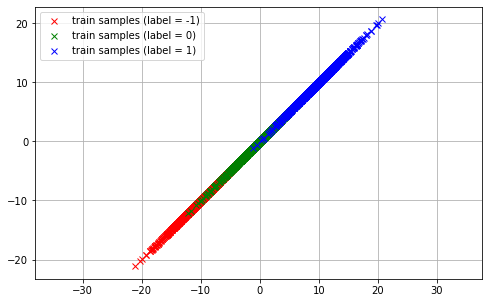

In [39]:
plt.figure(figsize=(8,5))
plt.axis("equal")

fmts = ["rx", "gx", "bx"]

for idx in range(len(labels)):
    plt.plot( sample[sample[:,2] == labels[idx]][:,0], sample[sample[:,2] == labels[idx]][:,1], fmts[idx], label="train samples (label = {:.0f})".format( labels[idx] ) )
    
plt.legend()
plt.grid()

In [11]:
sample

array([[ -3.85985386,  -3.85985386,  -1.        ],
       [-11.73995733, -11.73995733,  -1.        ],
       [-12.21796966, -12.21796966,  -1.        ],
       ...,
       [ 15.27782202,  15.27782202,   1.        ],
       [  2.62155683,   2.62155683,   1.        ],
       [ 13.12144971,  13.12144971,   1.        ]])

In [12]:
features = np.reshape( features, [-1,3])
for idx, x in enumerate( next_batch( features, 10) ):
    if idx > 10:
        break
    print(x.shape)

(10, 3)
(10, 3)
(10, 3)
(10, 3)
(10, 3)
(10, 3)
(10, 3)
(10, 3)
(10, 3)
(10, 3)
(10, 3)


In [13]:
tf.reset_default_graph()

p = 0.8
lamda = 0.1

input = tf.placeholder( tf.float32, [None,2] )
label = tf.placeholder( tf.float32, [None,1] )

with slim.arg_scope([slim.conv2d, slim.fully_connected],
                      activation_fn=tf.nn.relu,
                      weights_initializer=tf.truncated_normal_initializer(stddev=0.01)):

    x = slim.fully_connected(input, 32, scope='fc/fc_1')
    x = slim.fully_connected(x, 128, scope='fc/fc_2')
    x = slim.fully_connected(x, 128, scope='fc/fc_3')
    prediction = slim.fully_connected(x, 1, scope='fc/regression', activation_fn = None )
    confidence = slim.fully_connected(x, 1, scope='fc/confidence', activation_fn = None )
    
confidence = tf.math.sigmoid( confidence ) 

loss_basic = tf.square( label - prediction )

runtime_label = tf.py_func( runtime_label_ftn, [loss_basic, p], [tf.float32] )
loss_basic = tf.reduce_mean( loss_basic )
loss_confidence = loss_basic + lamda* tf.reduce_mean( tf.square(runtime_label-confidence) )

learning_rate = 0.001
global_step = tf.Variable( 0, trainable=False) 
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)

update_var_list = tf.get_collection( key = tf.GraphKeys.TRAINABLE_VARIABLES )
#print_var_status( update_var_list )

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    train_basic_op = optimizer.minimize(loss_basic,global_step=global_step )
    train_op = optimizer.minimize(loss_confidence,global_step=global_step )

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    - tf.numpy_function maintains the semantics of the deprecated tf.py_func
    (it is not differentiable, and manipulates numpy arrays). It drops the
    stateful argument making all functions stateful.
    


In [14]:
sum = 0 
all_vars = tf.trainable_variables() 
variable_dict = {} 
for var in all_vars: 
    current_tensor_size = tensor_size(var) 
    sum = sum + current_tensor_size 
    print("{}, {}, {}".format(var.name, var.get_shape(),current_tensor_size)) 

print( "total parameters =", sum) 

fc/fc_1/weights:0, (2, 32), 64
fc/fc_1/biases:0, (32,), 32
fc/fc_2/weights:0, (32, 128), 4096
fc/fc_2/biases:0, (128,), 128
fc/fc_3/weights:0, (128, 128), 16384
fc/fc_3/biases:0, (128,), 128
fc/regression/weights:0, (128, 1), 128
fc/regression/biases:0, (1,), 1
fc/confidence/weights:0, (128, 1), 128
fc/confidence/biases:0, (1,), 1
total parameters = 21090


In [15]:
batch_size = 80

regression_epochs = 4000
confidence_epochs = 4000

with tf.Session() as sess:
    sess.run( tf.global_variables_initializer() )
    
    for idx, x in enumerate( next_batch( features, batch_size) ):
        _loss, _ = sess.run( [loss_basic, train_basic_op], feed_dict={input:x[:,:2],label:x[:,2:3]})
        #if idx % 100 == 0:
        #    print(_loss)
        if idx > regression_epochs:
            break
            
    for idx, x in enumerate( next_batch( features, batch_size) ):
        _loss_confidence, _ = sess.run( [loss_confidence, train_op], feed_dict={input:x[:,:2],label:x[:,2:3]})
        #if idx % 100 == 0:
        #    print(_loss)
        if idx > confidence_epochs:
            break

    writer = tf.summary.FileWriter("./toy/graph",sess.graph)
    writer.close()

    _output = sess.run( prediction, feed_dict={input:test_vector})
    _confidence = sess.run( confidence, feed_dict={input:test_vector})
    
    saver = tf.train.Saver()
    save_path = saver.save( sess, "./toy/model/model_p_{}_lambda_{}.ckpt".format( p, lamda ) )

# model load

In [6]:
p = 0.8
lamda = 0.1

with tf.Session() as sess:
    new_saver = tf.train.import_meta_graph( "./toy/model/model_p_{}_lambda_{}.ckpt.meta".format( p, lamda ) )
    new_saver.restore(sess, "./toy/model/model_p_{}_lambda_{}.ckpt".format( p, lamda ) )
    
    tf.get_default_graph()
    
    input = sess.graph.get_tensor_by_name("Placeholder:0")
    prediction = sess.graph.get_tensor_by_name("fc/regression/BiasAdd:0")
    confidence = sess.graph.get_tensor_by_name("Sigmoid:0")
    
    _output = sess.run( prediction, feed_dict={input:test_vector})
    _confidence = sess.run( confidence, feed_dict={input:test_vector})
    #_output_free = sess.run( prediction, feed_dict={input:free_data})
    #_confidence_free = sess.run( confidence, feed_dict={input:free_data})

INFO:tensorflow:Restoring parameters from ./toy/model/model_p_0.8_lambda_0.1.ckpt


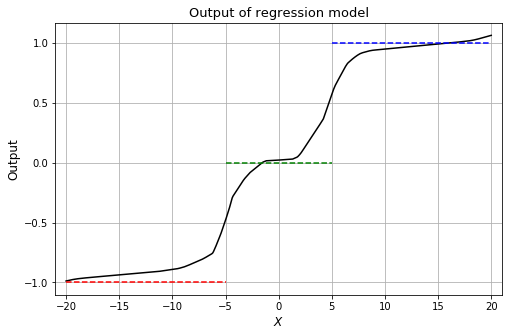

In [68]:
plt.figure(figsize=(8,5))

#plt.bar(hist1[1][1:], 2*hist1[0]/np.max(hist1[0]), bottom=-1, width=1, alpha=0.2, label="label -1 samples", color="red")
#plt.bar(hist2[1][1:], 2*hist2[0]/np.max(hist2[0]), bottom=-1, width=1, alpha=0.2, label="label 0 samples", color="green")
#plt.bar(hist3[1][1:], 2*hist3[0]/np.max(hist3[0]), bottom=-1, width=1, alpha=0.2, label="label 1 samples", color="blue")

plt.plot( test_vector[:,0], _output[:,0], "k-", label="Output of\nregression model" )
#plt.plot( test_vector[:,0], _confidence[:,0], color="orange", label="Output of\nconfidence model" )
#plt.plot( [-15,-5], [-1,-1])
#plt.plot( [-5,5], [0,0])
#plt.plot( [5,15], [1,1])
plt.plot( [-20,-5], [ labels[0], labels[0] ], "r--")
plt.plot( [-5,5], [ labels[1], labels[1] ], "g--")
plt.plot( [5,20], [ labels[2], labels[2] ], "b--")
plt.title("Output of regression model", fontsize=13)
plt.xlabel("$X$", fontsize=12)
plt.ylabel("Output", fontsize=12)
#plt.legend()
plt.grid()
#plt.ylim(-1.05,1.05)
plt.xlim(-21, 21)

plt.savefig("./figure/figure_toy_regression.png")

In [40]:
data1 = sample[sample[:,-1]==-1]
data2 = sample[sample[:,-1]==0]
data3 = sample[sample[:,-1]==1]

hist1 = np.histogram(data1[:,0], bins=20)
hist2 = np.histogram(data2[:,0], bins=20)
hist3 = np.histogram(data3[:,0], bins=20)

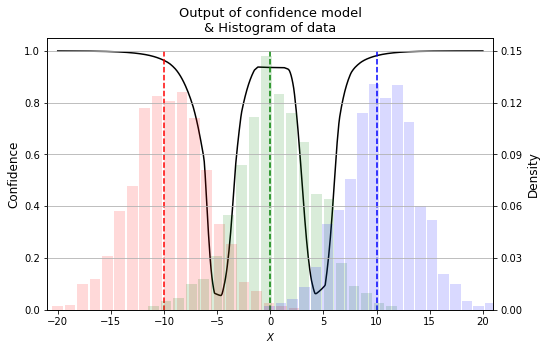

In [69]:
fig = plt.figure(figsize=(8,5))

ax1 = fig.add_subplot(1,1,1)
ax1.set_title("Output of confidence model\n& Histogram of data", fontsize=13)
ax1.set_xlabel("$X$")
ax1.set_ylabel("Confidence", fontsize=12)

ax1.plot( test_vector[:,0], _confidence[:,0], color="k" )
ax1.plot( [-10,-10], [1,0], 'r--' )
ax1.plot( [0,0], [1,0], 'g--' )
ax1.plot( [10,10], [1,0], 'b--' )
ax1.set_xlim(-21, 21)
ax1.set_yticks(np.arange(0,1.01,0.2))
ax1.set_ylim(0,1.05)

ax2 = ax1.twinx()
ax2.bar(hist1[1][1:], hist1[0]/len(data1), width=1, alpha=0.15, color="red")
ax2.bar(hist2[1][1:], hist2[0]/len(data2), width=1, alpha=0.15, color="green")
ax2.bar(hist3[1][1:], hist3[0]/len(data3), width=1, alpha=0.15, color="blue")
ax2.set_ylabel("Density", fontsize=12)
ax2.set_yticks(np.arange(0,0.16,0.03))
ax2.set_ylim(0, 0.1575)

plt.grid()

plt.savefig("./figure/figure_toy_confidence.png")